# Homework 2

### Due: Sun Oct. 21 @ 9pm

In this homework we'll perform a hypothesis test and clean some data before training a regression model.


## Instructions

Follow the comments below and fill in the blanks (____) to complete.

In [98]:
import pandas as pd
import numpy as np
from pprint import pprint
import seaborn as sns
import sklearn
import matplotlib.pylab as plt
import math
import statistics

# To suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

%matplotlib inline

## Part 1: Hypothesis Testing with an A/B test

Suppose we work at a large company that is developing online data science tools. Currently the tool has interface type A but we'd like to know if using interface tool B might be more efficient.
To measure this, we'll look at length of active work on a project (aka project length).
We'll perform an A/B test where half of the projects will use interface A and half will use interface B.

In [99]:
# read in project lengths from '../data/project_lengths'
# there should be 1000 observations for both interfaces
df_project = pd.read_csv('/Users/rainsunny/Desktop/COMSW4995_007_2018_3/data/project_lengths.csv')
df_project.info()
df_project.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
lengths_A    1000 non-null float64
lengths_B    1000 non-null float64
dtypes: float64(2)
memory usage: 15.7 KB


,lengths_A,lengths_B
0,5.191470,4.038233
1,3.265106,11.055010
2,50.170632,3.542817
3,3.411306,48.874282
4,39.300082,3.771299


In [100]:
# calculate the difference in mean project length between interface A and B
# for consistency, subtracting A from B
# hint: this number should be negative here (could interpret as faster)
mean_A = df_project['lengths_A'].mean()
mean_B = df_project['lengths_B'].mean()
observed_mean_diff = mean_B - mean_A
observed_mean_diff

-1.5819526645395978

In [101]:
# we'll perform a permutation test to see how significant this result is
# generate 10000 random permutation samples of mean difference
# hint: use np.random.permutation
rand_mean_diffs = []
n_samples = 10000
combined_times = np.concatenate([df_project.lengths_A.values, df_project.lengths_B.values])
n_A = len(df_project.loc[:,'lengths_A']) # number of observations for page A
for i in range(n_samples):
    rand_perm = np.random.permutation(combined_times)
    rand_mean_A = rand_perm[:n_A].mean()
    rand_mean_B = rand_perm[n_A:].mean()
    rand_mean_diffs.append(rand_mean_B-rand_mean_A)

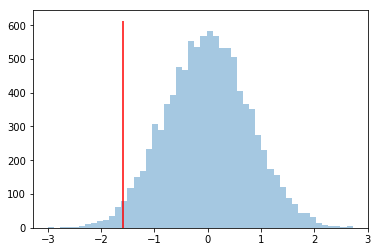

In [102]:
# use seaborn to plot the distribution of mean differences
# use plt.vlines to plot a line at our observed difference in means (ymin=0,ymax=0.5)
ax = sns.distplot(rand_mean_diffs, norm_hist=False, kde=False)
_ = plt.vlines(observed_mean_diff, *ax.get_ylim(), color='r')

In [103]:
# the plot should seem to indicate significance, but let's calculate a one-tailed p_value using rand_mean_diffs
p_value = sum(np.array(rand_mean_diffs) >= observed_mean_diff)/ len(rand_mean_diffs)
p_value

0.9795

In [104]:
# we can calculate the effect size of our observation
# this is the absolute value of the observed_mean_diff divided by the standard deviation of the combined_times
observed_effect_size = abs(observed_mean_diff)/statistics.stdev(combined_times)
observed_effect_size

0.0903556065848877

In [105]:
# we'll use this for the next 2 steps
from statsmodels.stats.power import tt_ind_solve_power

In [106]:
# what is the power of our current experiment?
# e.g. how likely is it that correctly decided that B is better than A 
#   given the observed effect size, number of observations and alpha level we used above
# since these are independent samples we can use tt_ind_solve_power
# hint: the power we get should not be good
power = tt_ind_solve_power(effect_size = observed_effect_size,  # what we just calculated
                           nobs1 = n_A,         # the number of observations in A
                           alpha = 0.05,        # our alpha level
                           power = None,        # what we're interested in
                           ratio = 1            # the ratio of number of observations of A and B
                          )
power

0.5237486906601911

In [107]:
# how many observations for each of A and B would we need to get a power of .9
#   for our observed effect size and alpha level
# eg. having a 90% change of correctly deciding B is better than A
n_obs_A = tt_ind_solve_power(effect_size = observed_effect_size,
                             nobs1 = None,
                             alpha = 0.05,
                             power = 0.9,
                             ratio = 1
                            )
n_obs_A

2575.0041335595133

## Part 2: Data Cleaning and Regression

### Data Preparation and Exploration

This data is provided by World Bank Open Data https://data.worldbank.org/, processed as in Homework 1.

We will be performing regression with respect to GDP and classification with respect to Income Group.
To do that we will first need to do a little more data prep.

In [108]:
# read in the data
df_country = pd.read_csv('/Users/rainsunny/Desktop/COMSW4995_007_2018_3/data/country_electricity_by_region.csv')

# rename columns for ease of reference
columns = ['country_code','short_name','region','income_group','access_to_electricity','gdp','population_density',
           'population_total','unemployment','region_europe','region_latin_america_and_caribbean',
           'region_middle_east_and_north_africa','region_north_america','region_south_asia',
           'region_subsaharan_africa']

df_country.columns = columns
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 15 columns):
country_code                           217 non-null object
short_name                             217 non-null object
region                                 217 non-null object
income_group                           217 non-null object
access_to_electricity                  217 non-null float64
gdp                                    193 non-null float64
population_density                     215 non-null float64
population_total                       216 non-null float64
unemployment                           113 non-null float64
region_europe                          217 non-null int64
region_latin_america_and_caribbean     217 non-null int64
region_middle_east_and_north_africa    217 non-null int64
region_north_america                   217 non-null int64
region_south_asia                      217 non-null int64
region_subsaharan_africa               217 non-null int64
dtypes: flo

In [109]:
# create a dummy variable 'gdp_missing' to indicate where 'gdp' is null
df_country['gdp_missing'] = df_country.gdp.isnull()

In [110]:
# use groupby to find the number of missing gpd by income_level
# write a lambda function to apply to the grouped data, counting the number of nulls per group
df_country.groupby('income_group').gdp.apply(lambda x: sum(x.isnull()))

income_group
High income            18
Low income              3
Lower middle income     1
Upper middle income     2
Name: gdp, dtype: int64

In [111]:
# fill in missing gdp values according to income_group mean
# to do this, group by income_group 
# then apply a lambda function to the gdp column that uses the fillna function, filling with the mean
# inplace is not available here, so assign back into the gdp column
df_country.gdp = df_country.groupby('income_group').gdp.apply(lambda x: x.fillna(x.mean()))

In [112]:
# assert that there are no longer any missing values in gdp
assert len(df_country['gdp_missing']) == len(df_country['gdp'])

In [113]:
# create 'populiation_density_missing' dummy variable
df_country['population_density_missing'] = df_country.population_density.isnull()

In [114]:
# fill in missing population_density with median, grouping by region
df_country.population_density = df_country.groupby('region').population_density.apply(lambda x: x.fillna(x.median()))

In [115]:
# create a normalized 'gdp_zscore' column
from sklearn import preprocessing
#df_country['gdp_zscore'] = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df_country[['gdp']].values.astype(float)))
df_country['gdp_zscore'] = (df_country.gdp-np.mean(df_country.gdp))/np.std(df_country.gdp)

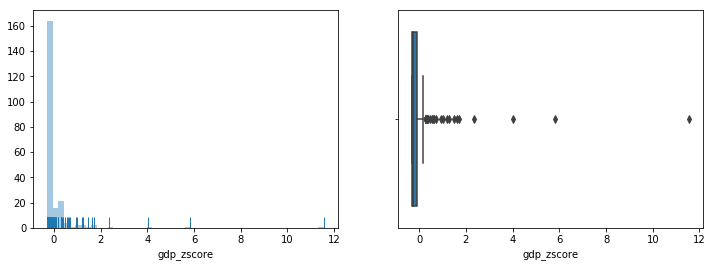

In [116]:
# use seaborn to create a distplot (with rugplot indicators) and a boxplot of gdp_zscores to visualize outliers
fig, ax = plt.subplots(1,2,figsize=(12,4))
_ = sns.distplot(df_country['gdp_zscore'], kde=False, rug=True,ax=ax[0])
_ = sns.boxplot(df_country['gdp_zscore'],ax=ax[1]) 

In [122]:
# print the top 10 country_code and gdp_zscore sorted by gdp_zscore
#print('The top 10 country_code and gdp_zscore are {} and {}'.format(df_country.sort_values('gdp_zscore',ascending=True).head(10).country_code,df_country.sort_values('gdp_zscore',ascending=True).head(10).gdp_zscore))
df_country.sort_values('gdp_zscore',ascending=False).head(10).country_code, df_country.sort_values('gdp_zscore',ascending=False).head(10).gdp_zscore


(203    USA
 36     CHN
 98     JPN
 50     DEU
 64     FRA
 68     GBR
 26     BRA
 89     IND
 95     ITA
 32     CAN
 Name: country_code, dtype: object, 203    11.552402
 36      5.807531
 98      4.035723
 50      2.365951
 64      1.717156
 68      1.626685
 26      1.479186
 89      1.264916
 95      1.201040
 32      1.007785
 Name: gdp_zscore, dtype: float64)

In [127]:
# set a zscore cutoff to remove the top 4 outliers
gdp_zscore_cutoff = [x for x in df_country.gdp_zscore if (x>1.8)]
#gdp_zscore_cutoff = np.array(df_country.gdp_zscore)[(df_country.gdp_zscore<=np.percentile(df_country.gdp_zscore,95))]
gdp_zscore_cutoff

[5.807531167773423, 2.3659507786737723, 4.035722917421101, 11.55240229646131]

In [119]:
# create a normalized 'population_density_zscore' column
#df_country['population_density_zscore'] = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df_country[['population_density']].values.astype(float)))
df_country['population_density_zscore'] = (df_country.population_density-np.mean(df_country.population_density))/np.std(df_country.population_density)

In [128]:
# print the top 10 country_code and population_density_zscore sorted by population_density_zscore
df_country.sort_values('population_density_zscore',ascending=False).head(10).country_code, df_country.sort_values('population_density_zscore',ascending=False).head(10).population_density_zscore


(118    MAC
 121    MCO
 170    SGP
 82     HKG
 71     GIB
 19     BHR
 124    MDV
 129    MLT
 24     BMU
 17     BGD
 Name: country_code, dtype: object, 118    9.660487
 121    9.474560
 170    3.703655
 82     3.287870
 71     1.512029
 19     0.662775
 124    0.461115
 129    0.460529
 24     0.443888
 17     0.404138
 Name: population_density_zscore, dtype: float64)

In [133]:
# set a zscore cutoff to remove the top 5 outliers
population_density_zscore_cutoff = [x for x in df_country.population_density_zscore if (x>1)]

In [134]:
# drop outliers (considering both gdp_zscore and population_density_zscore)
df_country = df_country[(x for x in df_country.gdp_zscore if not in gdp_zscore_cutoff) & (x for x in df_country.population_density_zscore if not in population_density_zscore_cutoff)]
df_country.shape

SyntaxError: invalid syntax (<ipython-input-134-b207a175cc57>, line 2)

### Train a Regression Model

In [ ]:
# create the training set of X with features (population_density, access_to_electricity) 
# and labels y (gdp)
X = df_country[['population_density','access_to_electricity']]
y = df_country['gdp']

In [ ]:
# import and initialize a LinearRegression model using default parameters
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [ ]:
# train the regressor on X and y
lr.fit(X,y)

In [ ]:
# print out the learned intercept and coefficients
print('beta_0 = {:0.3f}'.format(lr.intercept_))
print('beta_1 = {:0.3f}'.format(lr.coef_[0]))
print('beta_2 = {:0.3f}'.format(lr.coef_[1]))

In [ ]:
# we can use this mask to easily index into our dataset
country_mask = (df_country.country_code == 'CAN').values
df_country[country_mask]

In [ ]:
# how far off is our model's prediction for Canada's gdp (country_code CAN) from it's actual gdp?
df_country[country_mask]['gdp']  - lr.predict(df_country[country_mask][['population_density','access_to_electricity']])

In [ ]:
# create a new training set X that, in addition to population_density and access_to_electricity,
# also includes the region_* dummies
X = df_country[['population_density','access_to_electricity','region_europe','region_latin_america_and_caribbean',
           'region_middle_east_and_north_africa','region_north_america','region_south_asia',
           'region_subsaharan_africa']].values

In [ ]:
# instantiate a new model and train, with fit_intercept=False
regr = LinearRegression(fit_intercept=False)
regr.fit(X,y)

In [ ]:
# did the prediction for CAN improve?
np.abs(df_country[country_mask]['gdp']  - regr.predict(df_country[country_mask][['population_density','access_to_electricity','region_europe','region_latin_america_and_caribbean',
           'region_middle_east_and_north_africa','region_north_america','region_south_asia',
           'region_subsaharan_africa']]))
print('The prediction does not improve.')